## Feature Importance

from Notebook Filtering.ipynb after statistical Analyis, we continue this notebook with 5 dataframes :
**Original** dataframe as baseline for comparison. Contains 880 genera         
**uniques** unfiltered exclusive genera, contains 341 genera  
**uniques23** unfiltered exclusive genera plus common from categories 2 and 3, contains 773 genera      
**Influencers_OLS** filtered from original by threshold 0.2% abundance and frequency minimum of 3, selected genera using Ordinary Least Squares     
**OLS_all** selected data from the original underwent selection of significance by OLS.  
**uniques_OLS** selected from the original uniques Genera for each category were selected, posterior underwent selection of significance by OLS.   
**uniques_23_OLS** selected data from the original uniques Genera for each category, plus the common genera from category 2 and 3, posterior OLS.     
This notebook selects from original, uniques and uniques23 the 50 most influential features per pca analyis for the following df
**uniques_pca** from uniques after pca, made in this notebook, contains 51 genera      
**uniques23_pca** from uniques23 after pca contains        
**Influencers_uniques** from the mix of Influencers_OLS and uniques_OLS
  
Starting with 5 different df: OLS_all, Influencers_OLS, uniques_OLS, uniques_23_OLS, original apply the following pipelines
1. Apply Pipelines:
   * PCA visual scree plot and PCA scatterplot:
        These focus on the dimensionality reduction aspect and the structure of the data in the reduced space.  
   * PCA  Feature Influence , explained variance
     This focuses on how each feature contributes to the variance explained by the principal components.
   * Random Forest Regression- Feature importance
   * Random Forest Classification- Feature importance
2. Visually comparing Feature Importances and Influences:
   * Extract feature importances from the Random Forest models. 
     This focuses on the predictive power of each feature in the context of a Random Forest model
   * Extract feature influences from the PCA pipeline.
3. Replace IDs/GIDs with Biological Names:
   * Map the feature IDs to their corresponding biological names.
   * Analyze the biological significance of the selected features. For each dataframe and see if they make sense.
4. Combine and Select Most Influential Features:
   * Combine the results from different pipelines according to importance, influence and frequency into a DataFrame.
   * Select the top influential features

__Logistic Regression with L1 Regularization:__ This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
__Influence:__ Since the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights. Additionally at the end we have a list of most relevant Genera to continue to book 4.

In [534]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from IPython.display import display, HTML
from imblearn.over_sampling import SMOTE

In [535]:
pd.options.display.float_format = '{:.4f}'.format
#Reading the data
original  = pd.read_excel('data/original.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques   = pd.read_excel('data/uniques_unfiltered.xlsx', sheet_name='uniques', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques23 = pd.read_excel('data/uniques_unfiltered.xlsx', sheet_name='uniques23', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
OLS_all = pd.read_excel('data/OLS_all.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}}) 
Influencers_OLS = pd.read_excel('data/Influencers_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques_OLS = pd.read_excel('data/uniques_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques23_OLS = pd.read_excel('data/uniques23_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})

In [536]:
def clean_dataframe(df):
    return (df.drop(columns='Unnamed: 0', axis=1)
        .astype({'Sites': str, 'Category': int})
        .set_index("Sites"))

original = clean_dataframe(original)
uniques = clean_dataframe(uniques)
uniques23 = clean_dataframe(uniques23)
OLS_all = clean_dataframe(OLS_all)
Influencers_OLS = clean_dataframe(Influencers_OLS)
uniques_OLS= clean_dataframe(uniques_OLS)
uniques23_OLS= clean_dataframe(uniques23_OLS)

### PCA explained_variance_ratio -Screeplot and PCA plot

In [537]:
def prepare_data(df, category_column, index_column=None):
    df_prepared = df.copy()
    if index_column:
        df_prepared = df_prepared.set_index(index_column)
    category = df_prepared[category_column]
    df_prepared = df_prepared.drop(columns=[category_column], axis=1)
    return df_prepared, category

def standardize_data(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return pd.DataFrame(X_scaled, columns=df.columns)

def perform_pca(X_scaled, n_components=None):
    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    return pca, X_pca, explained_variance_ratio, cumulative_variance_ratio

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(7, 5))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(title) # "Explained Variance Ratio by Principal Components"
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_pca_2d(X_pca, category, title):
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Category'] = category.values
    colors = ['green', 'orange', 'red']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)
    plt.title(title)# "Data Points in Reduced Dimensional Space (PCA)"
    plt.show()

def pca_pipeline(df, category_column, index_column=None, n_components=None, dataset_name=None):
    df_prepared, category = prepare_data(df, category_column, index_column)
    X_scaled = standardize_data(df_prepared)

    # Perform PCA with all components for scree plot
    pca_all = PCA()
    pca_all.fit(X_scaled)
    explained_variance_ratio = pca_all.explained_variance_ratio_
    
    # Perform PCA with selected components for visualization
    pca, X_pca, explained_variance_ratio, cumulative_variance_ratio = perform_pca(X_scaled, n_components)
    
    if dataset_name:
        plot_scree(pca_all, f"Scree Plot for {dataset_name}")
        plot_pca_2d(X_pca, category, f"PCA 2D Visualization for {dataset_name}")
    
    results = {
        'pca': pca,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'X_pca': X_pca
    }
    return results

### PCA Feature Importance and Explained Variance by Original Feature

In [538]:
def apply_pipeline_pca(df, dataset_name, n_components, n_top_features=20):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target
    X = df.drop(columns=['Category', 'Sites'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
                    
    # Fit the pipeline to the training data
    pca_pipeline.fit(X_train)

    # Extract the number of components and explained variance
    n_components = pca_pipeline.named_steps['pca'].n_components_
    
    # Get the loadings from the PCA object
    loadings = pca_pipeline.named_steps['pca'].components_
    
    # Calculate the absolute sum of loadings for each feature
    feature_influence = np.sum(np.abs(loadings), axis=0)
    
    # Create DataFrame with feature influences
    df_pca_influence = pd.DataFrame({
        'Features': X.columns,
        'Influence': feature_influence
    }).sort_values(by='Influence', ascending=False)

    # Limit the DataFrame to the top n_top_features
    df_pca_influence = df_pca_influence.head(n_top_features)

   # Explained variance by original feature
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'Explained Variance Ratio':  pca_pipeline.named_steps['pca'].explained_variance_ratio_
    }).head(25)
    
    return pca_pipeline, df_pca_influence, explained_variance, n_components

### Diplaying the Results

In [539]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

### Computing PCA and Varianza -Scree Plots for Original
Original dataframe as baseline for comparison

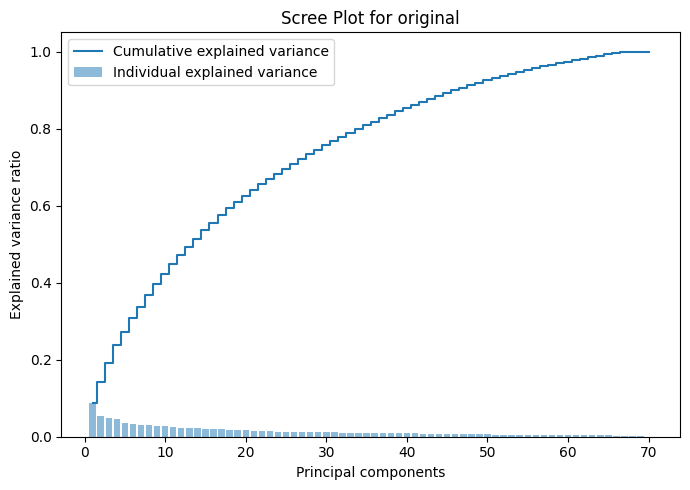

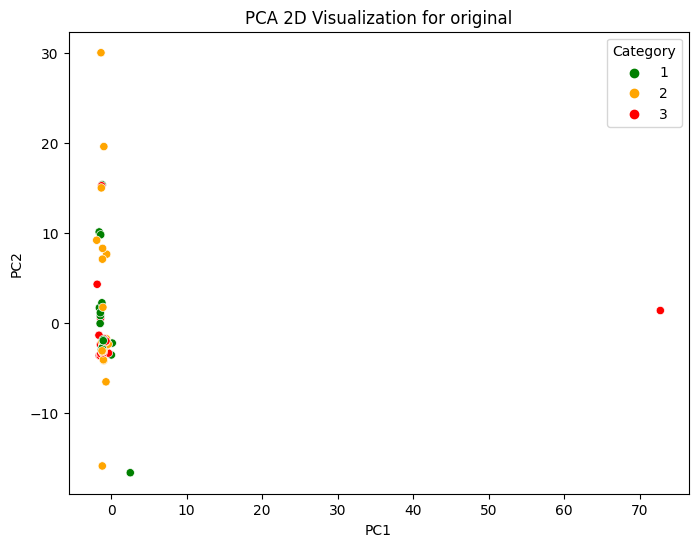

original_pipeline:


,Features,Influence
269,270,1.5642
726,727,1.5504
150,151,1.5448
473,474,1.5426
686,687,1.5250
417,418,1.5038
662,663,1.5036
200,201,1.4990
563,564,1.4871
40,41,1.4770


In [540]:
# Aply pipeline for visual results
original_pca = pca_pipeline(original, 'Category', n_components=2, dataset_name='original')

# Apply the pipeline for numerical results
original_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(original, "original", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

In [541]:
print(*df_pca_influence["Features"].values.tolist())

270 727 151 474 687 418 663 201 564 41 552 148 487 155 607 223 18 865 254 308 227 574 526 81 639 367 172 491 166 660 585 145 108 705 733 584 250 341 561 271 84 300 323 211 259 229 551 670 373 269


**original**:
   - original shows no aglomeration nor useful information which is expected the noise due to the large amount of data and features/sample ratio. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named original_pca and is composed of 51 features.

In [542]:
df_pca_influence_columns = df_pca_influence["Features"].values.tolist()
original_pca = original[["Category"] + df_pca_influence_columns]  

### Computing PCA and Varianza -Scree Plots for uniques
selected data from the original only unique genera per category is in this dataframe of 343 genera.

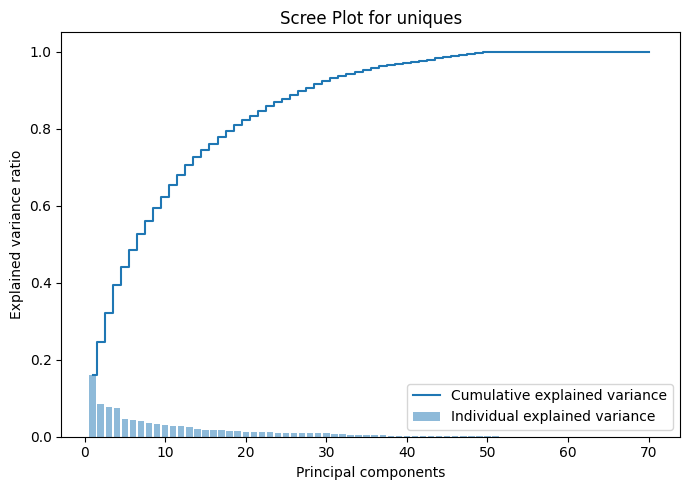

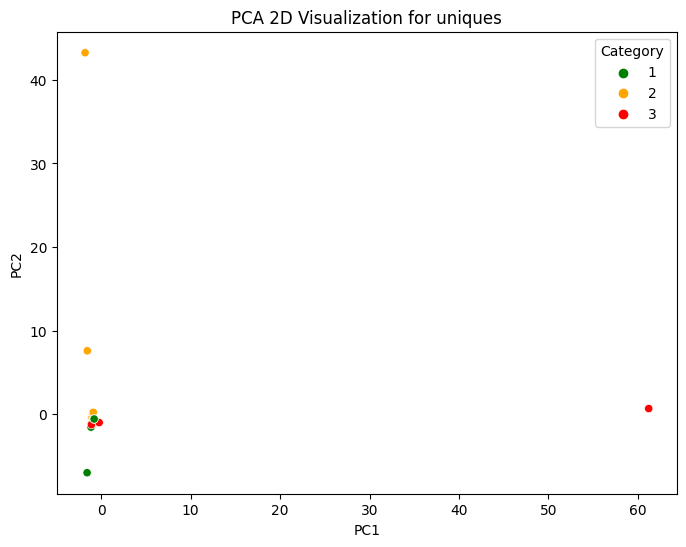

uniques_pipeline:


,Features,Influence
70,190,1.4667
201,578,1.4243
56,160,1.4206
240,696,1.4206
154,457,1.4163
206,594,1.4163
122,361,1.4163
47,123,1.4059
88,240,1.4059
133,396,1.4059


In [543]:
# Aply pipeline for visual results
uniques_pca = pca_pipeline(uniques, 'Category', n_components=2, dataset_name='uniques')

# Apply the pipeline for numerical results
uniques_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(uniques, "uniques", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**uniques**
The explained variance improves referent to original df but the pca plot show very little diferenciation. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques_pca and is composed of 51 features.

In [544]:
# print the genera from this pca to check
#print(f"Genera uniques : {df_pca_influence['Features'].values.tolist()}")
print(*df_pca_influence['Features'].values.tolist())

190 578 160 696 457 594 361 123 240 396 418 680 201 87 704 649 427 477 46 78 355 511 385 2 242 879 571 698 244 122 22 639 367 197 410 85 436 635 558 132 494 636 872 225 104 621 239 576 382 856


In [545]:
df_pca_influence_columns = df_pca_influence["Features"].values.tolist()
uniques_pca = uniques[["Category"] + df_pca_influence_columns]  

In [546]:
uniques_pca.head()

,Category,190,578,160,696,457,594,361,123,240,...,494,636,872,225,104,621,239,576,382,856
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_4,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0022,0.0022,0.0022,0.0044,0.0066,0.0000,0.0000,0.0000,0.0000,0.0000
site_5,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Computing PCA and Varianza -Scree Plots for uniques23
selected data from the original only unique genera per category is in this dataframe plus the common genera between 2 and 3 categories, contains 771 genera.

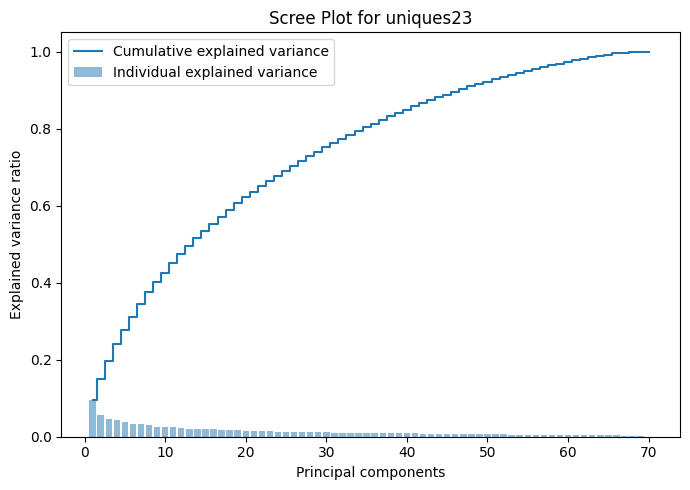

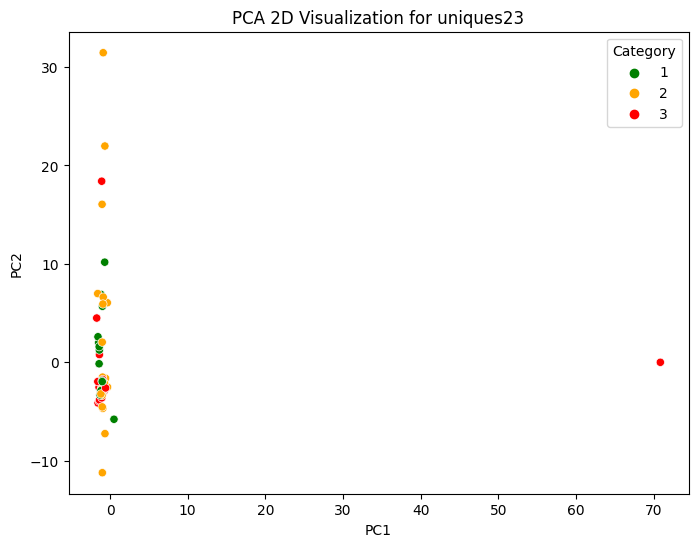

uniques23_pipeline:


,Features,Influence
232,270,1.6479
34,41,1.6337
462,526,1.6334
144,172,1.6141
754,865,1.5939
129,151,1.5925
260,300,1.5901
15,18,1.5842
485,552,1.5828
427,487,1.5738


In [547]:
# Aply pipeline for visual results
uniques23_pca = pca_pipeline(uniques23, 'Category', n_components=2, dataset_name='uniques23')

# Apply the pipeline for numerical results
uniques23_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(uniques23, "uniques23", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**uniques23**
The explained variance is worse than uniques df and the pca plot show very little diferenciation. Notive that some influencer genera that are in original_pca are also on unique_pca. The first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques23_pca and is composed of 51 features.

In [548]:
print(*df_pca_influence["Features"].values.tolist())

270 41 526 172 865 151 300 18 552 487 474 323 663 687 108 491 148 574 250 86 373 535 245 127 308 561 214 276 660 155 455 563 330 269 575 81 254 484 551 271 607 194 140 709 566 529 497 572 389 200


In [549]:
df_pca_influence_columns = df_pca_influence["Features"].values.tolist()
uniques23_pca = uniques23[["Category"] + df_pca_influence_columns] 

### Computing PCA and Varianza -Scree Plots for Influencers_OLS
selected data from the original with abundance threshold of 0,2% and frequency of 3, underwent selection of significance by OLS

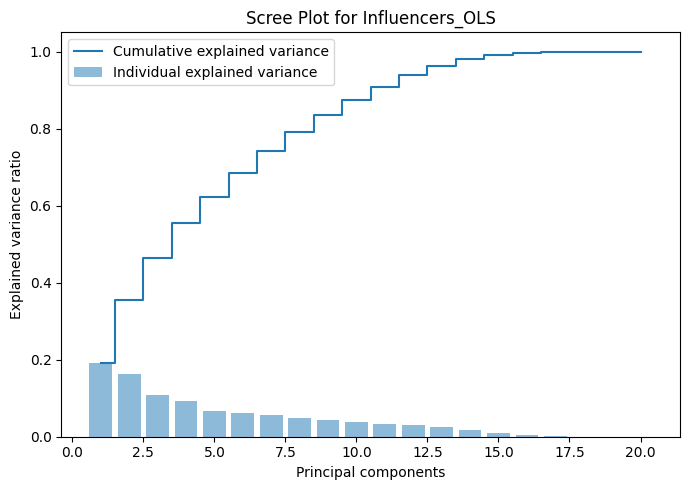

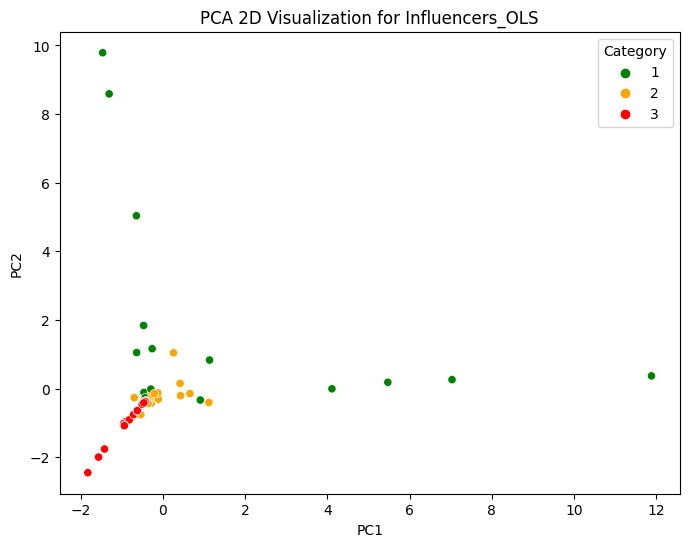

Influencers_OLS_pipeline:


,Features,Influence
18,351,2.3880
6,214,2.2835
8,678,2.2209
0,863,2.1979
3,526,2.1441
4,584,2.0509
2,408,1.9783
10,864,1.6802
11,471,1.6356
15,91,1.4883


In [550]:
# Aply pipeline for visual results
Influencers_OLS_pca = pca_pipeline(Influencers_OLS, 'Category', n_components=2, dataset_name='Influencers_OLS')
# Apply the pipeline for numerical results
Influencers_OLS_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(Influencers_OLS, "Influencers_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**Influencers_OLS**:
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and 1. 
   - Category 3 There is a clear regression trend in category 3 
   - Category 2 dots align in the middle, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'v' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories.  

__Scree Plots:__ The Influencers_OLS dataset appears to decrease its explained variance more steeply compared to the OLS_all dataset.

### Computing PCA and Varianza -Scree Plots for OLS_all
selected data from the original underwent selection of significance by OLS.

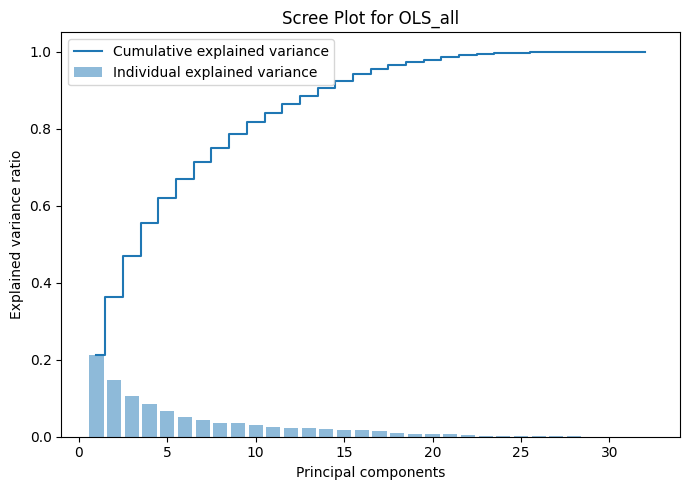

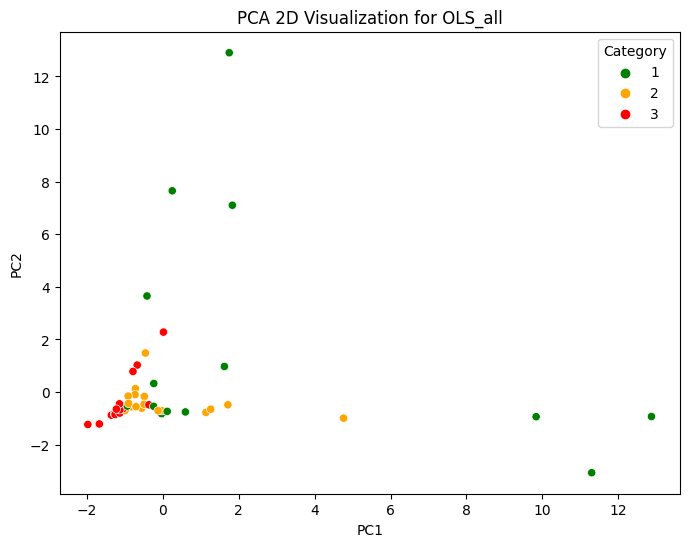

OLS_all_pipeline:


,Features,Influence
28,92,2.8745
4,584,2.7563
22,625,2.7317
21,229,2.6060
3,201,2.5696
14,678,2.4565
26,470,2.4488
9,428,2.2496
17,342,2.1915
2,657,2.0984


In [551]:
# Aply pipeline for visual results
OLS_all_pca = pca_pipeline(OLS_all, 'Category', n_components=2, dataset_name='OLS_all')
# Apply the pipeline for numerical results
OLS_all_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(OLS_all, "OLS_all", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**OLS_all**:
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.

In both scree plots, OLS_all and Influencers_OLS a clear "elbow point" is observed around the 5th principal component. This suggests that retaining the first 5 components captures a significant portion of the variance in the data. However, Influencers_OLS seems to achieve a higher explanatory power with fewer features compared to OLS_all, moreover the differentiation on the labels makes this dataset more relevant. According to the principle of parsimony or Occam's Razor, which states that among competing hypotheses, the one with the fewest assumptions should be selected, in this case Influencers_OLS. Until the biological significance is not accounted for, the datasets are to be retained for comparison.

### Computing PCA and Varianza -Scree Plots for uniques_OLS
selected data from the original only Genera samples that do no share category were selected, posterior underwent selection of significance by OLS.

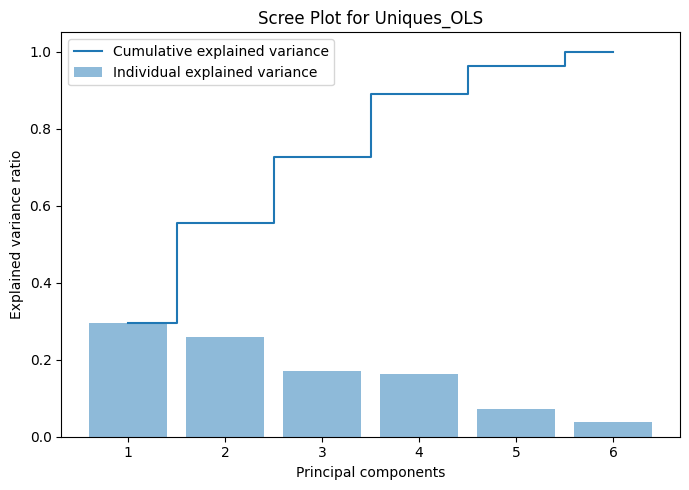

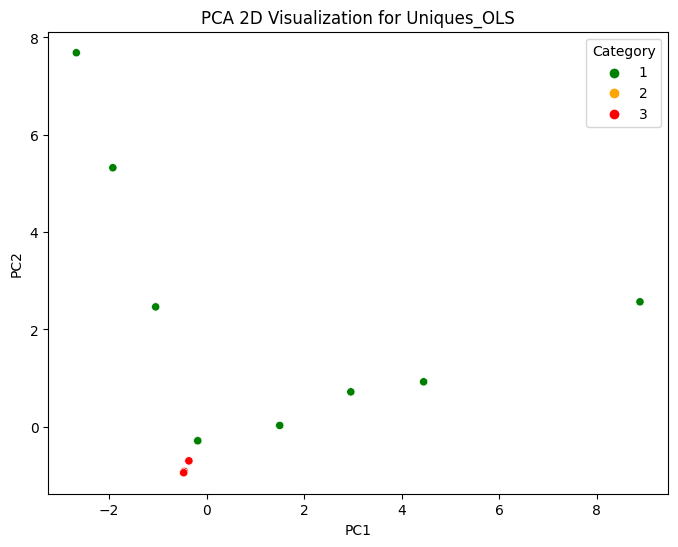

Uniques_OLS_pipeline:


,Features,Influence
5,410,2.0235
1,342,1.9286
2,799,1.7271
4,201,1.4755
3,494,1.0109
0,541,0.9773
,Component,Explained Variance Ratio
0,1,0.3172
1,2,0.2873
2,3,0.1732


In [552]:
# Aply pipeline for visual results
uniques_OLS_pca = pca_pipeline(uniques_OLS, 'Category', n_components=2, dataset_name='Uniques_OLS')
# Apply the pipeline for numerical results
uniques_OLS_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(uniques_OLS, "Uniques_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**uniques_OLS**:
   - Uniques_OLS is compound of only 6 features and interestingly it shows the best differenciation on the pca of the components. Also the varianza increases from 0.2 on the previous dfs to 0.3 explained variance. Showing that this features can explain better the dataset in reference to the corrosion rick label. 
   - The v shape of the category 1 is very clear and so is the lineal presence of category 3.  

### Computing PCA and Varianza -Scree Plots for uniques_23_OLS
selected data from the original only Genera samples that do no share category were selected, plus the common genera from category 2 and 3, posterior underwent selection of significance by OLS.

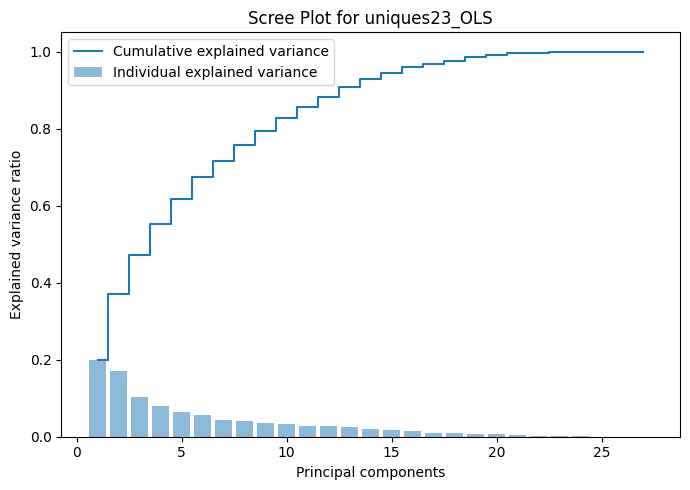

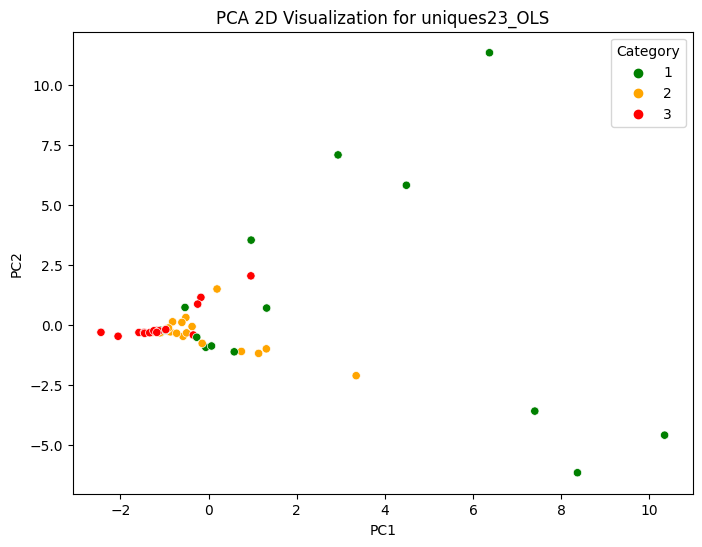

uniques23_OLS_pipeline:


,Features,Influence
19,625,2.5578
2,584,2.5408
1,201,2.4363
18,229,2.4231
16,799,2.3797
12,678,2.2436
26,88,2.1551
5,214,2.0959
17,410,2.0397
10,140,1.9158


In [553]:
# Aply pipeline for visual results
uniques23_OLS_pca = pca_pipeline(uniques23_OLS, 'Category', n_components=2, dataset_name='uniques23_OLS')
# Apply the pipeline for numerical results
uniques23_OLS_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(uniques23_OLS, "uniques23_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**unique_23__OLS**:
   - Uniques_23 is compose of more as 300 features and interestingly shows the worst differenciation blobs on the pca components. Also the varianza decreases from 0.3 on the previous df to 0.2 explained variance. Showing that this features have to be decreased in order to increase significance in reference to the corrosion rick label. 
   - Category 1 has very clear separation similar to the previous dataframes, however 2 and 3 are overlaped yet feature 3 continues to present a lineal regresion between the two PC.

### Pipeline for Regression

In [554]:
def apply_pipeline_regressor(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  # 
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target
    X = df.drop(columns=['Category', 'Sites'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    rf_mae_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    
        # Fit and predict
        rf_pipeline.fit(X_train, y_train)
        # Predict the labels of the test set
        y_pred = rf_pipeline.predict(X_test)
    
        # Calculate and store MAE
        mae = mean_absolute_error(y_test, y_pred).round(4)
        rf_mae_scores.append(mae)

    print(f"Cross-Validation MAE Scores for RF: {rf_mae_scores}")
    print(f"Average MAE for RF: {np.mean(rf_mae_scores).round(4)}")
      
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred).round(4)
    print(f'Mean Squared Error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4)
    print(f'Root Mean Squared Error: {rmse}')
    mae = mean_absolute_error(y_test, y_pred).round(4)
    print(f'Mean Absolute Error: {mae}')

    # Extract feature importances from RandomForestRegressor
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
            'Features': X.columns,
            'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False) # Sort the features by importance
    
    print(f'Feature Importance by RF: {df_importances_rf.head(25)}')
          
    return rf_pipeline, df_importances_rf

* **MSE (Mean Squared Error):** Measures the average of the squares of the errors.
* __RMSE (Root Mean Squared Error):__ Square root of MSE. It's in the same units as the output variable and gives a higher penalty for larger errors.
* __MAE (Mean Absolute Error):__ Measures the average of the absolute errors.

### Pipeline for Clasification

In [555]:
def apply_classification_pipeline_classif(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  # 
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target
    X = df.drop(columns=['Category', 'Sites'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTE to handle class imbalance by resampling the minority class
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Reshape target variables after SMOTE for consistency
    y_train_resampled = y_train_resampled.ravel()
    y_test = y_test.ravel() 

    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    rf_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
  
        # Fit and predict
        rf_pipeline.fit(X_train_resampled, y_train_resampled)
        # Predict the labels of the test set
        y_pred = rf_pipeline.predict(X_test)
    
        # Calculate and store accuracy
        accuracy = accuracy_score(y_test, y_pred).round(4)
        rf_scores.append(accuracy)

    print(f"Cross-Validation Accuracy Scores for RF: {rf_scores}")
    print(f"Average Accuracy for RF: {np.mean(rf_scores).round(4)}")
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Extract feature importances from RandomForestClassifier
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
            'Features': X.columns,
            'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False) # Sort the features by importance
    
    print(f'Feature Importance by RF: {df_importances_rf}')
          
    return rf_pipeline, df_importances_rf

In [556]:
# Apply pipeline Regression
original_pca_pipeline_reg, df_importances_reg= apply_pipeline_regressor(original_pca, "original_pca")
# Apply the pipeline Classification
original_pca_pipe_class, df_importances = apply_classification_pipeline_classif(original_pca, "original_pca")

original_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.7843, 0.7029, 0.4971, 0.6521, 0.7414]
Average MAE for RF: 0.6756
Mean Squared Error: 0.8185
Root Mean Squared Error: 0.9047
Mean Absolute Error: 0.7414
Feature Importance by RF:    Features  Importance
42      323      0.1183
27      491      0.0882
22      526      0.0829
16       18      0.0829
49      269      0.0649
45      229      0.0601
0       270      0.0534
39      271      0.0454
8       564      0.0429
38      561      0.0381
3       474      0.0373
4       687      0.0347
34      733      0.0319
19      308      0.0250
23       81      0.0204
33      705      0.0179
13      155      0.0166
28      166      0.0127
29      660      0.0110
18      254      0.0108
36      250      0.0105
41      300      0.0102
1       727      0.0101
17      865      0.0087
31      145      0.0080
original_pca_pipeline:
Cross-Validation Accuracy Scores for RF: [0.8571, 0.9286, 0.9286, 0.8571, 0.9286]
Average Accuracy for RF: 0.9
Co

**Original_PCA_pipeline Regression**:
This pipeline shows moderate performance in regression and classification tasks. The Mean Absolute Error (MAE) is around 0.6756, with an average accuracy of 0.4571. The feature importance is distributed across multiple features, with features 323, 491, and 526 being the most significant. This pipeline does not seem to offer significant improvements over the existing pipelines.
**Original_pca_pipeline Classification**
Low cross-validation accuracy (0.4571) and inconsistent performance.
Class 1: Zero precision and recall, indicating an inability to classify this category.This pipeline is weaker than all of the others.

In [557]:
# Apply pipeline Regression
uniques_pca_pipeline_reg, df_importances_reg= apply_pipeline_regressor(uniques_pca, "uniques_pca")
# Apply the pipeline Classification
uniques_pca_pipe_class, df_importances = apply_classification_pipeline_classif(uniques_pca, "uniques_pca")

uniques_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6855, 0.552, 0.4355, 0.4274, 0.5506]
Average MAE for RF: 0.5302
Mean Squared Error: 0.5382
Root Mean Squared Error: 0.7336
Mean Absolute Error: 0.5506
Feature Importance by RF:    Features  Importance
10      418      0.1997
34      410      0.1751
1       578      0.1231
15      649      0.0448
11      680      0.0436
13       87      0.0389
36      436      0.0388
38      558      0.0328
14      704      0.0322
37      635      0.0311
40      494      0.0285
39      132      0.0283
12      201      0.0266
44      104      0.0230
16      427      0.0159
41      636      0.0147
43      225      0.0139
42      872      0.0139
45      621      0.0125
18       46      0.0123
3       696      0.0114
17      477      0.0109
2       160      0.0072
0       190      0.0051
19       78      0.0049
uniques_pca_pipeline:
Cross-Validation Accuracy Scores for RF: [0.5, 0.8571, 0.3571, 0.5, 0.6429]
Average Accuracy for RF: 0.5714
Confusio

**uniques_PCA_pipeline Regression**:
Moderate average MAE (0.5302) but still higher than Influencers_OLS.
Feature importance concentrated on a few features (e.g., 418, 410, 578).This pipeline is slightly better than original_pca_pipeline but not as strong as Influencers_OLS.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5714) but class imbalance issues.
Class 1: Zero precision and recall.
Class 2: Moderate precision and high recall.
Class 3: Perfect precision and recall but limited support. This pipeline is slightly better than original_pca_pipeline but still has significant class imbalance issues.

In [558]:
# Apply pipeline Regression
uniques23_pca_pipeline_reg, df_importances_reg= apply_pipeline_regressor(uniques23_pca, "uniques23_pca")
# Apply the pipeline Classification
uniques23_pca_pipe_class, df_importances = apply_classification_pipeline_classif(uniques23_pca, "uniques23_pca")

uniques23_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.8443, 0.6629, 0.4529, 0.5093, 0.6543]
Average MAE for RF: 0.6247
Mean Squared Error: 0.6347
Root Mean Squared Error: 0.7967
Mean Absolute Error: 0.6543
Feature Importance by RF:    Features  Importance
11      323      0.1204
15      491      0.0754
2       526      0.0666
26      214      0.0588
47      572      0.0556
33      269      0.0546
7        18      0.0526
22      245      0.0478
42      140      0.0446
45      529      0.0406
0       270      0.0389
10      474      0.0372
34      575      0.0337
25      561      0.0275
29      155      0.0253
24      308      0.0249
13      687      0.0228
37      484      0.0219
39      271      0.0206
27      276      0.0133
35       81      0.0128
28      660      0.0117
14      108      0.0110
6       300      0.0093
19       86      0.0082
uniques23_pca_pipeline:
Cross-Validation Accuracy Scores for RF: [0.9286, 0.9286, 0.8571, 0.9286, 0.9286]
Average Accuracy for RF: 0.91

**uniques_PCA_pipeline Regression**:
Higher average MAE (0.6247) and higher variability in MAE scores.
Feature importance distributed across multiple features. This pipeline does not offer significant improvements over the existing pipelines.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5286) with consistent but low accuracy across folds.
Class 1: Perfect precision but very low recall.
Class 2: Moderate precision and high recall.
Class 3: Zero precision and recall. This pipeline has similar issues to the other pipelines, particularly with class imbalance.

Analysing the three new created dfs from the pca dimensionality reduction step. We see that The uniques_pca_pipeline shows the lowest MAE, indicating it performs best in terms of prediction error. The uniques_pca_pipeline also has the highest accuracy.
Each pipeline has slightly different top features.
original_pca_pipeline top features: 42 323 (0.1183), 27 491 (0.0882)
uniques23_pca_pipeline top features: 11 323 (0.1204), 15 491 (0.0754)
uniques_pca_pipeline top features: 10 418 (0.1997), 34 410 (0.1751)

In [559]:
# Apply pipeline Regression
Influencers_pipeline_reg, Importances_rf_Influencers = apply_pipeline_regressor(Influencers_OLS, "Influencers_OLS")

# Apply the pipeline Classification
Influencers_pipe_class, importances_class_I = apply_classification_pipeline_classif(Influencers_OLS, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.3309, 0.2258, 0.1394, 0.1801, 0.3386]
Average MAE for RF: 0.243
Mean Squared Error: 0.2617
Root Mean Squared Error: 0.5116
Mean Absolute Error: 0.3386
Feature Importance by RF:    Features  Importance
3       526      0.4318
17      549      0.1764
13      625      0.1100
10      864      0.1091
6       214      0.0462
19      375      0.0309
12      229      0.0302
1       565      0.0223
2       408      0.0101
4       584      0.0072
14       23      0.0066
18      351      0.0064
15       91      0.0057
11      471      0.0034
0       863      0.0016
9       712      0.0013
16      334      0.0004
5       725      0.0004
7       871      0.0000
8       678      0.0000
Influencers_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.9286, 1.0, 1.0, 1.0, 0.9286]
Average Accuracy for RF: 0.9714
Confusion Matrix:
[[3 0 0]
 [0 7 0]
 [0 1 3]]

Classification Report:
              precision    recall  f1-score   support

**Influencers_OLS Pipeline Regression:**
Cross-Validation MAE Scores for RF: Consistently lower and less variable (ranging from 0.1426 to 0.34) with a significantly lower average MAE (0.242).
Error Metrics:
MSE: 0.2618; RMSE: 0.5116; MAE: 0.34  

These metrics demonstrate improved prediction accuracy and model reliability compared to OLS_all. Feature importance is more concentrated, with feature 526 having an overwhelming impact (importance: 0.4318). Other features like 549 and 625 show noticeable contributions but to a lesser extent.

**Influencers_OLS_pipeline Classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.8286 (high and consistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but lower recall (misclassifications lead to only 67% recall).  
Class 2: High recall (100%) but lower precision (64%).   
Class 3: High precision (100%) but very low recall (25%), indicating many false negatives.  
Classification Report:  
Macro average recall (0.64) suggests unbalanced performance across classes.  
Weighted average metrics reflect an overall acceptable but not ideal model for classifying all categories equally well.  
Feature Importance:  
Feature 526 dominates (23.26%), followed by moderately impactful features like 549 and 864.  

In [560]:
# Apply pipeline Regression
OLS_all_pipe_reg, importances_reg_OLS = apply_pipeline_regressor(OLS_all, "OLS_all")

# Apply the pipeline classification
OLS_all_pipe_class, importances_class = apply_classification_pipeline_classif(OLS_all, "OLS_all")

OLS_all_pipeline:
Cross-Validation MAE Scores for RF: [0.6993, 0.6044, 0.4021, 0.6127, 0.5673]
Average MAE for RF: 0.5772
Mean Squared Error: 0.391
Root Mean Squared Error: 0.6253
Mean Absolute Error: 0.5673
Feature Importance by RF:    Features  Importance
27      549      0.1870
23       23      0.1127
22      625      0.0874
7       214      0.0813
21      229      0.0805
12      140      0.0603
26      470      0.0501
4       584      0.0416
24       91      0.0411
0       565      0.0358
25      334      0.0321
14      678      0.0288
10      337      0.0206
16      605      0.0177
9       428      0.0172
1       771      0.0167
31       88      0.0167
5       725      0.0152
15      712      0.0108
30       79      0.0107
6       480      0.0063
18      799      0.0060
8       871      0.0060
13      426      0.0043
19       90      0.0030
OLS_all_pipeline:
Cross-Validation Accuracy Scores for RF: [0.8571, 0.9286, 0.8571, 0.9286, 1.0]
Average Accuracy for RF: 0.9143
Confusion Mat

**OLS_all_pipeline regression:**
Cross-Validation MAE Scores for RF: Higher variability across folds (ranging from 0.3935 to 0.6886) and a higher average MAE (0.5725) suggest that the model's predictive performance is less consistent.
Error Metrics:
Mean Squared Error (MSE): 0.3921; Root Mean Squared Error (RMSE): 0.6262;Mean Absolute Error (MAE): 0.5634
These metrics indicate lower prediction accuracy compared to the Influencers_OLS pipeline.
**Importance** is more evenly distributed, with no single feature dominating.
Top features (e.g., feature 549, 23, and 625) exhibit moderate importance values (0.1883, 0.1233, 0.0887).

**OLS_all_pipeline classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.4714 (significantly lower, inconsistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but extremely low recall (17%), with many false negatives.   
Class 2: Moderate precision (45%) and high recall (83%), indicating a focus on this class.  
Class 3: Zero precision and recall, indicating an inability to classify this category.  
Classification Report:   
Macro and weighted averages are much lower than Influencers_OLS, indicating an overall weaker model.  
Feature Importance:   
Importance is more distributed but lower overall contributions compared to Influencers_OLS.   

In [561]:
# Apply pipeline Regression
uniques_pipeline, importances_reg = apply_pipeline_regressor(uniques_OLS, "Uniques_OLS")
# Apply the pipeline Classification
uniques_pipe_class, importances_class = apply_classification_pipeline_classif(uniques_OLS, "unique_OLS")

Uniques_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.6963, 0.6703, 0.3817, 0.3783, 0.7327]
Average MAE for RF: 0.5719
Mean Squared Error: 0.7443
Root Mean Squared Error: 0.8628
Mean Absolute Error: 0.7327
Feature Importance by RF:   Features  Importance
0      541      0.2391
1      342      0.2319
5      410      0.2062
4      201      0.1734
2      799      0.1178
3      494      0.0315
unique_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.4286, 0.7143, 0.7143, 0.6429, 0.5]
Average Accuracy for RF: 0.6
Confusion Matrix:
[[1 5 0]
 [0 6 0]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.17      0.29         6
           2       0.46      1.00      0.63         6
           3       0.00      0.00      0.00         2

    accuracy                           0.50        14
   macro avg       0.49      0.39      0.31        14
weighted avg       0.63      0.50      0.39        14

Feature Importance b

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**uniques_OLS_pipeline Regression:**
Cross-Validation MAE Scores for RF: Higher variability (range 0.3783–0.7313) and a comparable average MAE (0.572).  
Error Metrics:  
MSE: 0.7412 ; RMSE: 0.8609 ; MAE: 0.7313 (relatively high).  These metrics are slightly higher than those of the unique23 pipeline, suggesting a slightly higher level of error.
These metrics reflect suboptimal predictive performance compared to other datasets.  
Feature Importance:   
Importance is relatively concentrated among the top three features (541: 0.2426, 342: 0.2327, 410: 0.2050), suggesting a model reliant on a few key variables.  
**uniques_OLS_pipeline Classification:**
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.4286 to 0.7143, with an average accuracy of 0.5429. This is slightly better than the unique23 pipeline but still shows variability.
Confusion Matrix and Classification Report:
Class 1: Zero precision and recall, indicating all instances of this class are misclassified.
Class 2: Perfect precision and recall for the instances classified, but the confusion matrix suggests many instances are not classified correctly.
Class 3: Zero precision and recall, similar to Class 1.
Features 229 and 214 have the highest importance (0.1008 and 0.0947, respectively), followed by features 549, 23, and 140. Distribution similar to the uniques23.

In [562]:
# Apply pipeline Regression
unique_23_OLS_pipeline_rg, importances_rf_uniques23= apply_pipeline_regressor(uniques23_OLS, "unique23_OLS")
# Apply the pipeline Classification
# Apply the pipeline the working df
uniques23_pipe_class, importances_class_U = apply_classification_pipeline_classif(uniques23_OLS, "unique23_OLS")

unique23_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.7057, 0.6129, 0.3854, 0.6169, 0.5446]
Average MAE for RF: 0.5731
Mean Squared Error: 0.3671
Root Mean Squared Error: 0.6059
Mean Absolute Error: 0.5446
Feature Importance by RF:    Features  Importance
24      549      0.1872
20       23      0.1113
19      625      0.0881
18      229      0.0805
5       214      0.0785
10      140      0.0659
23      470      0.0499
2       584      0.0453
21       91      0.0435
0       565      0.0318
22      334      0.0317
26       88      0.0260
7       428      0.0226
16      799      0.0218
8       337      0.0204
14      605      0.0197
12      678      0.0181
3       725      0.0129
4       480      0.0095
13      712      0.0088
6       871      0.0069
11      426      0.0066
15      342      0.0055
17      410      0.0035
1       201      0.0016
unique23_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.7857, 0.9286, 0.7857, 0.8571, 1.0]
Average Accuracy for RF: 0.8714
Co

**unique_23_OLS_pipeline Regression**:
Cross-Validation MAE Scores for RF: Less variability (range 0.3867–0.72) and slightly higher average MAE (0.5751).
Error Metrics:
MSE: 0.3868 ; RMSE: 0.622 ; MAE: 0.5623 (lower than uniques_OLS).These metrics indicate better performance than uniques_OLS, possibly due to the model leveraging a larger pool of features.

**Feature importance** is more evenly distributed across top contributors (e.g., 549: 0.1899, 23: 0.1025, 625: 0.0889). High-dimensionality could contribute to complexity but might also capture subtle interactions.  
**unique_23_OLS_pipeline Classification**:
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.3571 to 0.5714, with an average accuracy of 0.4429. This indicates a moderate level of classification accuracy with significant variability.
Confusion Matrix and Classification Report:
Class 1: Perfect precision but very low recall (0.17), indicating many false negatives.
Class 2: Moderate precision (0.45) and high recall (0.83).
Class 3: Zero precision and recall, indicating all instances of this class are misclassified. Macro average recall is 0.33, suggesting unbalanced performance across classes.
Feature Importance:
Feature 229 has the highest importance (0.1008), followed by features 214, 549, 23, and 140. This indicates a spread of importance across several features.

**unique_23_OLS_pipeline** achieves slightly better predictive accuracy despite higher dimensionality, possibly due to capturing more complex interactions, performs better numerically. Suggesting that the dataset's complexity adds value despite reduced interpretability.
**uniques_OLS_pipeline**, though concise, has poorer error metrics, indicating potential underfitting or missing interactions and struggles with predictive accuracy.

### Analysing the models Regression and Classification. 
Both pipelines struggle with class imbalance, leading to poor performance on certain classes.
Feature importance is similar but with slight variations, suggesting that the same set of features is important for classification in both pipelines.

**Integrating Influencers_OLS and uniques_OLS**
So analysing the Influencers_OLS results it is seen that it clasify well class 1 and 3, however having fewer members of class 1, and uniques_OLS is a small dataframe that shows good classification on class 1. So the join of the two will be check. It is comprised of 27 genera.
**Integrating OLS_all and uniques_OLS**
This is likely better option because uniques_OLS has shown better performance in classifying Class 1, which is a weakness in OLS_all_pipeline. The feature importance distribution and the strengths in classifying Class 1 make it a good complement. However looking at the merge of the two of them, there is no need to join them since uniques is part of all. 

In [563]:
# Merging the dataframes OLS_all and uniques_OLS on idex "Sites
all_uniques= pd.merge(OLS_all, uniques_OLS, left_index=True, right_index=True, suffixes =('_all', '_uniques'))
# Drop any duplicate columns 
all_uniques= all_uniques.loc[:, ~all_uniques.columns.duplicated()]
all_uniques= all_uniques.drop(columns="Category_uniques")
all_uniques = all_uniques.rename(columns={"Category_all" : "Category"})
all_uniques.columns

Index(['Category', '565', '771', '657', '201_all', '584', '725', '480', '214',
       '871', '428', '337', '541_all', '140', '426', '678', '712', '605',
       '342_all', '799_all', '90', '410_all', '229', '625', '23', '91', '334',
       '470', '549', '92', '494_all', '79', '88', '541_uniques', '342_uniques',
       '799_uniques', '494_uniques', '201_uniques', '410_uniques'],
      dtype='object')

In [564]:
# Ensure that the Sites index is sorted properly
Influencers_OLS = Influencers_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))
uniques_OLS = uniques_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))

In [565]:
# Merging the dataframes Influencers_OLS and uniques_OLS on idex "Sites
Influencers_uniques= pd.merge(Influencers_OLS, uniques_OLS, left_index=True, right_index=True, suffixes =('_Influencers', '_uniques'))
# Drop any duplicate columns 
Influencers_uniques= Influencers_uniques.loc[:, ~Influencers_uniques.columns.duplicated()]
Influencers_uniques= Influencers_uniques.drop(columns="Category_uniques")
Influencers_uniques = Influencers_uniques.rename(columns={"Category_Influencers" : "Category"})
Influencers_uniques = Influencers_uniques.reset_index()

In [566]:
Influencers_uniques = Influencers_uniques.astype({"Sites": str, "Category": int})
Influencers_uniques = Influencers_uniques.set_index("Sites")

In [567]:
Influencers_uniques.head()

,Category,863,565,408,526,584,725,214,871,678,...,334,549,351,375,541,342,799,494,201,410
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0000,0.0000,0.1508,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_10,2,0.0000,0.0000,2.4800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_11,3,0.0000,0.0000,0.2047,0.0767,0.0767,0.0000,0.9210,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_12,3,0.0000,0.0000,0.0749,0.0336,0.1188,0.0000,0.3021,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_13,3,0.0000,0.0000,3.1560,0.0000,0.0595,0.0000,0.6947,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


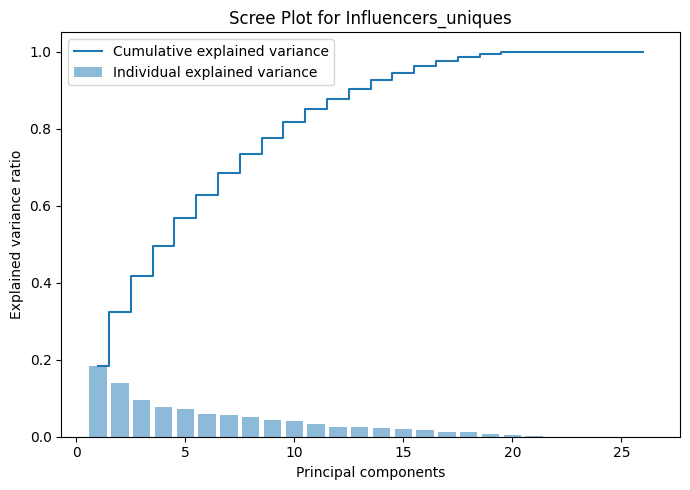

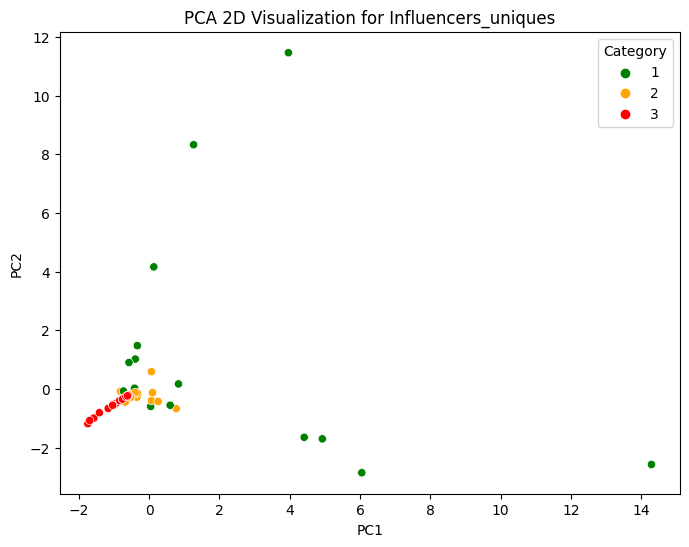

Influencers_uniques_pipeline:


,Features,Influence
4,584,2.9203
2,408,2.8256
18,351,2.8227
6,214,2.6949
24,201,2.5993
3,526,2.5717
0,863,2.5081
5,725,2.3191
11,471,2.2744
22,799,2.2594


Influencers_uniques_pipeline:
Cross-Validation MAE Scores for RF: [0.3318, 0.2245, 0.1419, 0.1791, 0.3286]
Average MAE for RF: 0.2412
Mean Squared Error: 0.251
Root Mean Squared Error: 0.501
Mean Absolute Error: 0.3286
Feature Importance by RF:    Features  Importance
3       526      0.4293
17      549      0.2101
10      864      0.0913
13      625      0.0709
6       214      0.0470
19      375      0.0339
1       565      0.0306
12      229      0.0283
2       408      0.0111
22      799      0.0097
14       23      0.0074
11      471      0.0065
15       91      0.0057
4       584      0.0056
18      351      0.0054
25      410      0.0027
0       863      0.0016
5       725      0.0016
16      334      0.0008
9       712      0.0004
8       678      0.0000
7       871      0.0000
20      541      0.0000
21      342      0.0000
23      494      0.0000
Influencers_uniques_pipeline:
Cross-Validation Accuracy Scores for RF: [0.9286, 1.0, 1.0, 1.0, 0.8571]
Average Accuracy for RF: 0.9

In [568]:
# Aply pipeline for visual results
Influencers_uniques_pca = pca_pipeline(Influencers_uniques, 'Category', n_components=2, dataset_name='Influencers_uniques')

# Apply the pipeline for numerical results
Influencers_uniques_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(Influencers_uniques, "Influencers_uniques", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
Influencers_uniques_pipeline_reg, importances_reg= apply_pipeline_regressor(Influencers_uniques, "Influencers_uniques")
# Apply the pipeline Classification
Influencers_uniques_pipe_class, importances_class = apply_classification_pipeline_classif(Influencers_uniques, "Influencers_uniques")

**Influencers_uniques pipeline Regression**:
The model is performing well with low MAE variability, ranging from 0.1415 to 0.3307 and an average MAE of 0.24. Compared to previous datasets (like uniques_OLS_pipeline where the variability was higher), this suggests an improved and more reliable model.
MSE (0.2523) and RMSE (0.5022) indicate moderate error levels, which suggest the model is performing reasonably well in terms of prediction accuracy. These are substantially better than earlier models where error levels were high.
**Feature importance** 
Feature 526 stands out as the most significant with an importance score of 0.4293, followed by feature 549 at 0.2017. These scores point to a few dominating features, which aligns with my future approach of combining the most influential features across datasets. This can potentially improve both feature selection and model generalization when merged. Indeed, the features indicate a focus on a few predictors that contribute heavily to the outcome. This could be useful when aim to reduce features but still retain biologically relevant ones.  
**Influencers_uniques_pipeline Classification**:
Cross-Validation Accuracy: This model achieved an average classification accuracy of 0.9571, which is quite strong. The relatively high accuracy, along with a well-balanced confusion matrix, suggests that the model can differentiate well across the three categories.  
Confusion Matrix & Classification Report:
    Class 1: Precision is perfect (1.0), but recall suffers (0.67), indicating that there may be a misclassification problem with certain examples.
    Class 2: High recall (1.0), but lower precision (0.78), meaning the model is good at catching all instances of Class 2 but sometimes incorrectly classifies other categories as Class 2.
    Class 3: Very high precision (1.0) but lower recall (0.75), indicating some false negatives are present, but the classification of class 3 is still accurate when it happens.

This classification model is performing fairly well but could be further refined, especially in terms of recall for classes 1 and 3, perhaps with tweaks in model parameters.

Feature Importance: The top three most important features (526, 549, and 864) once again highlight a few dominating predictors. These feature priorities would be the core of my focus, moving forward into the feature selection across datasets using biological relevance.

Influencers_uniques regression performance is improving with reduced error and a more concentrated feature importance distribution. This is promising for further refinement. The classification performance suggests some room for improvement, particularly in balancing recall and precision across classes, especially for Class 1 and 3. Combining datasets with influential features and considering their biological relevance for dimensionality reduction is an effective way forward.
Feature selection based on importance, variance, and biological significance will help ensure the model remains robust while simplifying feature sets.

SAVING COMBINED FEATURES 
The dataframes with a significant degree of importance for the next phase will be retained. Uniques_OLS has already been combined to create Influencers_uniques. The original features' PCA performance may provide valuable insights into predicting overall behavior and will be carried forward as original_pca. However, dataframes such as uniques_pca, uniques23_pca, uniques23_OLS, and original do not demonstrate notable contributions toward improving the models. As a result, they will be dropped in this notebook after extracting their three most important features. The dataframe OLS_all will undergo further processing in the subsequent steps.
In order to get the most important Features that make up the dfs that will be discarded, the dfs will be join together and passed through the pipelines of this notebook, then we will have another df "mergers"

In [569]:
# Colecting all columns names and ensure column names are all strings, strip and standardize)
original.columns = original.columns.astype(str).str.strip()  
original_pca_columns = [str(col).strip() for col in original_pca.columns.tolist()]
uniques_pca_columns = [str(col).strip() for col in uniques_pca.columns.tolist()]
uniques23_pca_columns = [str(col).strip() for col in uniques23_pca.columns.tolist()]
uniques23_OLS_columns = [str(col).strip() for col in uniques23_OLS.columns.tolist()]
OLS_all_columns = [str(col).strip() for col in OLS_all.columns.tolist()]

In [577]:
# Combine and deduplicate
merged_columns = list(set(original_pca_columns + 
                          uniques_pca_columns + 
                          uniques23_pca_columns + 
                          uniques23_OLS_columns + 
                          OLS_all_columns))

# Filter only columns available in original
original_columns = [str(col) for col in original.columns.tolist()]  # Ensure consistency in data types
valid_columns = [col for col in merged_columns if col in original_columns]

# Extract data for these columns from the original dataframe
Merged_df = original[merged_columns]

# Verify results
print(Merged_df.head())
print(f"Number of features in merged_df: {Merged_df.shape[1]}")

          636    225    535    342    670     78    160    649    660    585  \
Sites                                                                          
site_1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.5295 0.0000   
site_2 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.9106 0.0000   
site_3 0.0000 0.0000 0.0000 0.0000 0.0246 0.0000 0.0000 0.0000 1.0557 0.0000   
site_4 0.0022 0.0044 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.9278 0.0000   
site_5 0.0000 0.0000 0.0000 0.0000 0.0018 0.0000 0.0000 0.0000 1.3620 0.0000   

        ...    271    879     88    491    566    151    308    108    269  \
Sites   ...                                                                  
site_1  ... 8.7462 0.0000 0.0000 0.0862 0.0000 0.0000 0.0000 0.0646 0.0000   
site_2  ... 0.4933 0.0000 0.0190 0.0759 0.0000 0.0000 0.0000 0.0569 0.0000   
site_3  ... 0.7488 0.0000 0.0123 0.2210 0.0000 0.0000 0.0123 0.0123 0.0000   
site_4  ... 1.6660 0.0000 0.0154 0.0397 0.0000 0.

In [575]:
# Step 1: Clean column names (strip and standardize)
original.columns = original.columns.astype(str).str.strip()  # Strip spaces, and ensure they are strings
original_pca_columns = [str(col).strip() for col in original_pca.columns.tolist()]
uniques_pca_columns = [str(col).strip() for col in uniques_pca.columns.tolist()]
uniques23_pca_columns = [str(col).strip() for col in uniques23_pca.columns.tolist()]
uniques23_OLS_columns = [str(col).strip() for col in uniques23_OLS.columns.tolist()]
OLS_all_columns = [str(col).strip() for col in OLS_all.columns.tolist()]

# Step 2: Find missing columns by comparing
merged_columns = (original_pca_columns + uniques_pca_columns + 
                  uniques23_pca_columns + uniques23_OLS_columns + OLS_all_columns)

missing_columns = [col for col in merged_columns if col not in original.columns]

# Step 3: If missing columns found, report
if missing_columns:
    print(f"These columns are missing from the original dataframe: {missing_columns}")
else:
    print("No columns missing. Proceeding with the merge.")

# Step 4: Merge only existing columns
valid_columns = [col for col in merged_columns if col in original.columns]

# Step 5: Merge Dataframe
merged_df_debug = original[valid_columns]

# Verify merge result
print(merged_df_debug.head())
print(f"Valid features in merged dataframe: {merged_df_debug.shape[1]}")

No columns missing. Proceeding with the merge.
        Category    270    727    151    474    687    418    663    201  \
Sites                                                                      
site_1         3 0.5170 0.0000 0.0000 0.0000 0.0862 0.0000 0.0000 0.0000   
site_2         1 0.2277 0.0000 0.0000 0.0000 0.1138 0.0000 0.0000 0.0000   
site_3         1 1.9642 0.0000 0.0000 0.0000 0.1719 0.0000 0.0000 0.0000   
site_4         1 0.3173 0.0022 0.0000 0.0000 0.1036 0.0000 0.0000 0.0000   
site_5         1 0.3626 0.0000 0.0000 0.0000 0.0847 0.0000 0.0000 0.0000   

          564  ...    625     23     91    334    470    549     92    494  \
Sites          ...                                                           
site_1 0.0000  ... 0.0000 0.2801 0.1939 0.0215 0.0000 0.2154 0.0000 0.0000   
site_2 0.0190  ... 0.0000 1.2332 0.1138 0.0000 0.0000 0.3035 0.0000 0.0000   
site_3 0.0123  ... 0.0000 0.3069 0.2332 0.0000 0.0000 0.3069 0.0000 0.0000   
site_4 0.0154  ... 0.0044 2.20

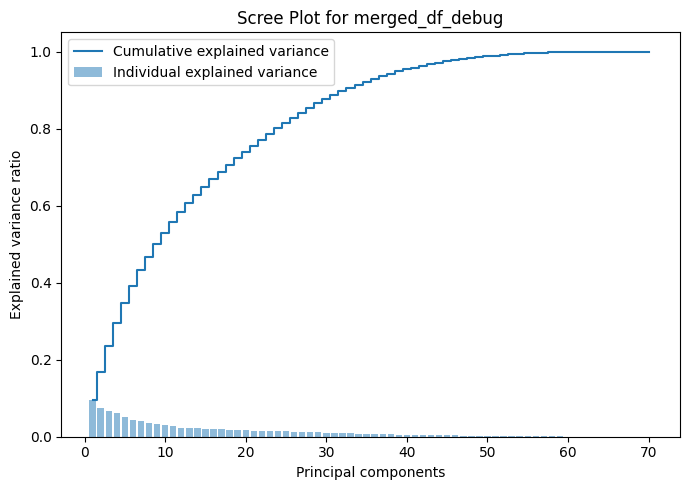

ValueError: Wrong number of items passed 5, placement implies 1

In [579]:
# Aply pipeline for visual results
merged_df_debug_pca = pca_pipeline(merged_df_debug, 'Category', n_components=2, dataset_name='merged_df_debug')

# Apply the pipeline for numerical results
merged_df_debug_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(merged_df_debug, "merged_df_debug", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
merged_df_debug_pipeline_reg, importances_reg= apply_pipeline_regressor(merged_df_debug, "merged_df_debug")
# Apply the pipeline Classification
merged_df_debug_pipe_class, importances_class = apply_classification_pipeline_classif(merged_df_debug, "merged_df_debug")


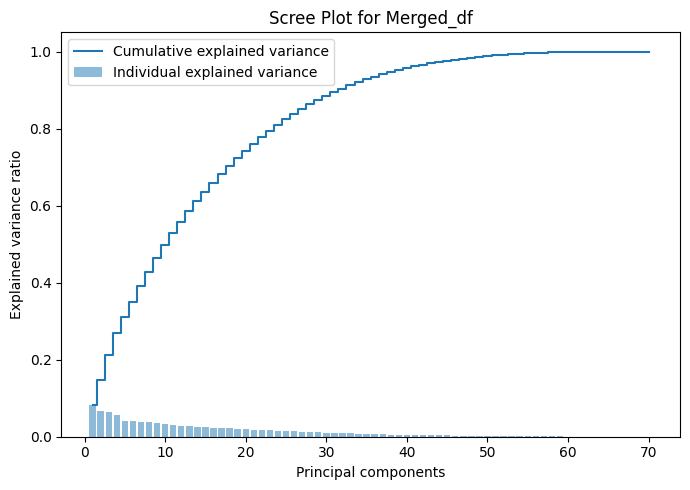

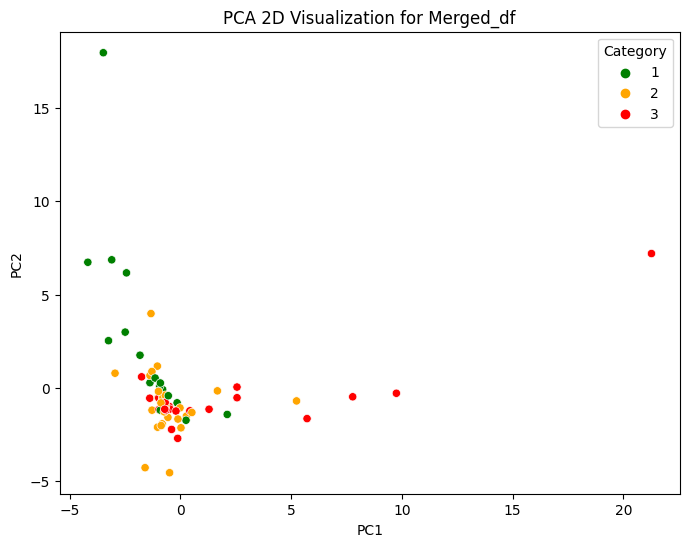

Merged_df_pipeline:


Merged_df_pipeline:
Cross-Validation MAE Scores for RF: [0.8093, 0.5514, 0.3721, 0.3879, 0.6007]
Average MAE for RF: 0.5443
Mean Squared Error: 0.5196
Root Mean Squared Error: 0.7208
Mean Absolute Error: 0.6007
Feature Importance by RF:     Features  Importance
115      549      0.1315
134      491      0.0670
20       323      0.0602
88       526      0.0543
36       625      0.0456
75        23      0.0454
139      269      0.0337
91       245      0.0336
95       214      0.0326
17       484      0.0276
94       572      0.0269
49       270      0.0245
53       229      0.0228
98       140      0.0208
28        18      0.0203
29       529      0.0189
102      474      0.0156
128      428      0.0154
15       561      0.0153
105      470      0.0152
117       91      0.0146
48       565      0.0145
100      334      0.0136
68       727      0.0126
90       687      0.0123
Merged_df_pipeline:
Cross-Validation Accuracy Scores for RF: [0.9286, 0.9286, 0.9286, 0.9286, 0.9286]
Average Acc

In [578]:
# Aply pipeline for visual results
Merged_df_pca = pca_pipeline(Merged_df, 'Category', n_components=2, dataset_name='Merged_df')

# Apply the pipeline for numerical results
Merged_df_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(Merged_df, "Merged_df", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
Merged_df_pipeline_reg, importances_reg= apply_pipeline_regressor(Merged_df, "Merged_df")
# Apply the pipeline Classification
Merged_df_pipe_class, importances_class = apply_classification_pipeline_classif(Merged_df, "Merged_df")


In [573]:
# Save multiple dataframes to different sheets in the same Excel file
with pd.ExcelWriter(f'data/uniques_unfiltered.xlsx') as writer:
    original_pca.to_excel(writer, sheet_name='original_pca', index=True)
    uniques23.to_excel(writer, sheet_name='uniques23', index=True)
    Influencers_uniques.to_excel(writer, sheet_name='Influencers_uniques', index=True)

## Comparison of the Feature Importance and Feature Influence
### Influencers_OLS, OLS_all and uniques_23 

In [574]:
# Create a function to display side-by-side
def display_side_by_side(*args, titles=()):
    """Display multiple DataFrames side-by-side."""
    html_str = '<div style="display:flex;">'
    for df, title in zip(args, titles):
        html_str += f'<div style="margin-right:20px;"><h3>{title}</h3>' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the data side-by-side
display_side_by_side(df_pca_influence_influencers, Importances_rf_Influencers, df_pca_influence_OLS_all, importances_rf_OLS, df_pca_influence_uniques23, importances_rf_uniques23,  
                     titles=["PCA Influence influencers", "RF Feature Importance influencers", "PCA Influence OLS_all", "RF Feature Importance OLS_all",  "PCA Influence uniques_23", "RF Feature Importance uniques_23"])

NameError: name 'df_pca_influence_influencers' is not defined

### Manually prunning the features according to importance and influence

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7] , dtype={**{i: str for i in range(0,2)},
                                                                        **{i:float for i in range(2, 884)}},  skiprows=[8]) # Somehow it was showing an empty row, so skiprow deletes it

# Making sure the sites and categories get read as they should
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].values.astype(int)
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
Jointax = Jointax.reset_index(drop=True)
#Setting the sites as index
Jointax = Jointax.set_index("Sites").reset_index()
# Deleting headers names of unnamed levels
Jointax.columns = Jointax.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
#Drop level of Kindom since it is boring
Jointax =Jointax.drop(Jointax.columns[1], axis=1)
#Correcting the Tuple-like Index
Jointax['Sites'] = Jointax['Sites'].map(lambda x: x[0] if isinstance(x, tuple) else x)
Jointax = Jointax.set_index("Sites")

I put all dataframes whole, Influencers, Uniques, Uniques_23 
Selected_Gids = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}

In [335]:
# The df were compared on excel, the most important features and influencial with pca and rf were selected on each df and pruned for replicates, then all df were mixed and chosen the following genera
selected_dfs_gen = 154,201, 214, 229, 334,351, 408, 354, 497,512,565, 581, 583, 584, 606, 621, 625
#selected_dfs_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512 # new selected-->
selected_dfs_gen = set(map(str, selected_dfs_gen))

In [336]:
# Initialize an empty list to store the columns to keep
columns_to_keep_dfs = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in selected_dfs_gen:
        columns_to_keep_dfs.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_dfs = Jointax.loc[:, columns_to_keep_dfs]

In [ ]:
# Add back the 'Sites' and 'Category' columns
selected_dfs['Sites'] = Jointax['Sites']
selected_dfs['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_dfs.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_dfs  = selected_dfs .loc[:, cols]
# Name the levels of the MultiIndex
selected_dfs.columns.names = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6', 'Level7']
# Create a DataFrame of NaNs with the same shape as the first row of the DataFrame to match pipeline starter df
nan_df = pd.DataFrame([np.nan]*selected_dfs.shape[1]).T
nan_df.columns = selected_dfs.columns

# Concatenate the NaN row and the original DataFrame
selected_dfs = pd.concat([nan_df, selected_dfs]).reset_index(drop=False)
selected_dfs.head()


In [ ]:
selected_pipeline, df_importances_rf= apply_pipeline(selected_dfs, "Selected_dfs_rf")

Selected_1 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625  
Mean Absolute Error: 0.5314   
Selected_2 = 154, 214, 229, 334, 336, 351, 408, 354, 471, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 471  
Mean Absolute Error: 0.5371  
Selected_3 = 214, 229, 334, 336, 351, 408, 354, 471, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 471-154
Mean Absolute Error: 0.5386  
Selected_4 = 23, 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 23
Mean Absolute Error: 0.5493  
Selected_5 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 +85
Mean Absolute Error: 0.5364  
Selected_5 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625  -606
Mean Absolute Error: 0.5514  
+91
Mean Absolute Error: 0.5814  
+2
Mean Absolute Error: 0.5371  
+201
Mean Absolute Error: 0.5264  
+238
Mean Absolute Error: 0.5421  
-336
Mean Absolute Error: 0.5343
+340
Mean Absolute Error: 0.5193
+342
Mean Absolute Error: 0.5143
+201+340+342
Mean Absolute Error: 0.5329
selected_dfs_gen = 154, 214, 229, 334,351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625,342,340,201,428
Mean Absolute Error: 0.5679
+470
Mean Absolute Error: 0.5393
-541
Mean Absolute Error: 0.5179
-541-512
Mean Absolute Error: 0.5364
-512
Mean Absolute Error: 0.5393
+512-541
Mean Absolute Error: 0.5179
-565
Mean Absolute Error: 0.5514
-606
Mean Absolute Error: 0.5407
+,657+705+863+864+871

no no

In [ ]:
selected_pipeline_pca, df_pca_influence= apply_pipeline_pca(selected_dfs, "Selected_dfs_pca")

### Loop to iterate existent selected Genera 
Now I will make a loop to iterate the existing genera and iteratively replace just one to see which model perform better in order to prune more features

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [ ]:
# Original selected GIDs
selected_gen_fin = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}
selected_gen_fin = set(map(str, selected_gen_fin))

mae_results = {}  # Initialize an empty dictionary to store MAE results

for gid_to_remove in selected_gen_fin:
    print(f"Removing GID: {gid_to_remove}")  # Debugging line
    
    # Temporarily remove one GID
    modified_gids = [x for x in selected_gen_fin if x != gid_to_remove]
    
    # Initialize an empty list to store the columns to keep
    columns_to_keep_fin = []
    
    # Filtering original DataFrame to only include the modified GIDs
    for col in Jointax.columns[2:]:
        gid = str(col[-1])
        if gid in modified_gids:
            columns_to_keep_fin.append(col)
            
    selected_dfs_fin = Jointax.loc[:, columns_to_keep_fin]
    
    # Add back the 'Sites' and 'Category' columns
    selected_dfs_fin['Sites'] = Jointax['Sites']
    selected_dfs_fin['Category'] = Jointax['Category']
      
    # Run pipeline here with the modified_df and get the MAE
    mae = apply_pipeline(selected_dfs_fin, "Modified_Gids")
    
    # Store the MAE result
    mae_results[f'Remove {gid_to_remove}'] = mae

print(mae_results)


| Mean Absolute Error | 0.4438 |
|---------------------|--------|
| **GID**             | **Join_tax**                                         | **Importance** |
| 625                 | Rhodospirillales_Acetobacteraceae_Roseococcus        | 0.1296         |
| 214                 | Clostridiales_Clostridiaceae_Clostridium             | 0.1234         |
| 408                 | Legionellales_Legionellaceae_Legionella              | 0.1132         |
| 229                 | Actinomycetales_Corynebacteriaceae_Corynebacterium   | 0.1052         |
| 351                 | Pasteurellales_Pasteurellaceae_Haemophilus           | 0.1043         |
| 354                 | Oceanospirillales_Halomonadaceae_Halomonas           | 0.1001         |
| 565                 | Bacteroidales_Porphyromonadaceae_Porphyromonas       | 0.0849         |
| 606                 | Xanthomonadale_Paracoccaceae_Rhodobacter             | 0.0564         |
| 334                 | Thermoanaerobacterales_Thermoanaerobacteraceae_XXX   | 0.0517         |
| 584                 | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas | 0.0438         |
| 583                 | Actinomycetales_Micrococcaceae_Pseudarthrobacter     | 0.0306         |
| 621                 | Burkholderiales_Comamonadaceae_Roseateles            | 0.0245         |
| 581                 | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3       | 0.0207         |
| 497                 | Actinomycetales_Cellulomonadaceae_Oerskovia          | 0.0062         |
| 512                 | Clostridiales_Clostridiaceae_Oxobacter               | 0.0055         |


In [59]:
original_pca.to_excel("data/original_pca.xlsx", index=True, engine='openpyxl')
uniques_pca.to_excel("data/uniques_pca.xlsx", index=True, engine='openpyxl')
uniques23_pca.to_excel("data/uniques23_pca.xlsx", index=True, engine='openpyxl')
Influencers_uniques_OLS.to_excel("data/Influencers_uniques_OLS.xlsx", index=True, engine='openpyxl')

| GID  | Join_tax                                              | Importance |   | GID  | Join_tax                                              | Influence |
|------|-------------------------------------------------------|------------|---|------|-------------------------------------------------------|-----------|
| 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 0.1578     |   | 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 2.5536    |
| 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 0.1568     |   | 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 2.5225    |
| 408  | Legionellales_Legionellaceae_Legionella               | 0.1230     |   | 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 2.3413    |
| 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 0.1044     |   | 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 2.2417    |
| 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 0.0930     |   | 408  | Legionellales_Legionellaceae_Legionella               | 2.2394    |
| 214  | Clostridiales_Clostridiaceae_Clostridium              | 0.0925     |   | 621  | Burkholderiales_Comamonadaceae_Roseateles             | 2.2278    |
| 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 0.0675     |   | 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 2.2168    |
| 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 0.0462     |   | 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 2.1489    |
| 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 0.0443     |   | 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 2.0918    |
| 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 0.0387     |   | 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 1.9865    |
| 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 0.0274     |   | 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 1.7623    |
| 621  | Burkholderiales_Comamonadaceae_Roseateles             | 0.0230     |   | 214  | Clostridiales_Clostridiaceae_Clostridium              | 1.7298    |
| 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 0.0196     |   | 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 1.7265    |
| 512  | Clostridiales_Clostridiaceae_Oxobacter                | 0.0032     |   | 512  | Clostridiales_Clostridiaceae_Oxobacter                | 1.5879    |
| 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 0.0025     |   | 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 1.3106    |


__Consistency in Top Features:__ Both datasets identified Phenylobacterium as the most influential feature. This consistency suggests that this genus plays a pivotal role in the dataset, regardless of the data's granularity.
Variability in Other Features: Beyond the top feature, there's a noticeable divergence in the ranking of genera between the two datasets. This is expected given the different preprocessing steps applied to each dataset.

__Biological Significance:__ The consistent identification of Phenylobacterium in both datasets underscores its potential biological significance. It might be worthwhile to delve deeper into the biological properties or ecological roles of this genus.
__Influence of Data Granularity:__ The influencers genera dataset, being a filtered subset, might capture more specific interactions or characteristics that are overshadowed in the whole dataset. On the other hand, the whole dataset provides a broader perspective, encompassing a wider range of genera interactions.
__Consideration of Other Important Features:__ While the influencers genera dataset offers a more focused view, it might be prudent to consider some of the top features from the whole data. Some of these features, though not present in the filtered dataset, might still play a significant role in the broader microbial community.

__Data Preprocessing:__ The difference in feature importance rankings between the two datasets underscores the impact of data preprocessing. While filtering out low-abundance genera can reduce noise, it might also inadvertently remove genera that play crucial roles in specific contexts.
__Incorporating Biological Knowledge:__ Feature importance derived from machine learning models should be interpreted in conjunction with biological knowledge. For instance, if a genus known to play a vital role in a particular microbial interaction is ranked low, it might be worth revisiting the data or the model.
__Complementary Analysis:__ Consider performing other analyses, like network analysis or pathway enrichment, to gain more insights into the interactions between these top-ranking genera. This can provide a more holistic view of the microbial community's dynamics.
In conclusion, while both datasets offer valuable insights, a balanced approach that considers both the focused view of the influencers and the broader perspective of the whole data might yield the most comprehensive understanding of the microbial community.

I could try to make a combination of the two datasets so to capture all the possible influence from these features, however the problem I see with the combination fo the whole and influencers dataframes is the overlaping of 1 and 3 categories. In the influencers at least there is no this problem, as we can see in the pc1 vs pca2 visualisation. On the other hand there maybe data that I discarded because of abundance and can actually be really good marker, even if trace occurence. 

I am ploting a combination of the two df to visually compare the distribution of each feature across both datasets. Features that have significantly different distributions between the two datasets might be causing the observed differences in PCA or RandomForestRegression results.

From our analysis, it's evident that the importance of specific bacteria in describing the data isn't necessarily associated with a particular category. At this stage, our primary objective is to identify features that align with the labels, rather than pinpointing features that exclusively mark category 3. Ideally, we should identify distinct markers for each category. 

My hesitation to integrate the two dataframes, is valid. One dataframe, final_influencers was differenciated better amongst categories on the pca plot. On the contrary final_whole has some overlapping.  Some of the genera that we see in the plots are really bad markers, for instance veillonella spreads on category 1 for a lot of sites, and have high abundance on two sites, there is a site on categories 2 and 3, so it is present ubiquotus anyway and it actually could be problematic, but actually also lives on no compromised systems, so no a definitive good marker. Similar hapends with other several genera. Few of them have high numbers on category 3, there is no really one genus that represents 1 because they also belong to the others categories. Category 2 on the other hand only have 3 clear representatives one of them mixed with 3 and the other two sites mixed with category one. Let analyse Rhodanobacter, this genus spreads in category 1 from 0 to 1.4 : 0 , 0.15, 0.156, 0.8, 0.81, 1, 1.4 in category 2 we have 0, 0.1, 0.15,  0.18, 0.35, 0.5 but then category 3 is 0, 0.65, 1.18. Yet another specimen that is on the three categories with easy. Upon literature inspection Rhodanobacter tend to form biofilms which could be protective forming a protective barrier against corrosion.

Some fundamental challenges in microbiome research:

1. **Variability in Microbiome Data**: Microbiome data is inherently noisy. The presence or abundance of a particular bacterial genus or species can vary widely even among individuals in the same category. This variability can be due to numerous factors, including diet, genetics, environment, and more.

2. **Marker Bacteria**: Ideally, marker bacteria should be specific to a particular category and not present (or present in very low abundance) in others. However, in real-world data, it's rare to find such clear-cut markers. As we can observe, many bacteria are present across categories, making them less useful as discriminative markers.

3. **Biological Significance vs. Statistical Significance**: Just because a bacterium is statistically associated with a category doesn't mean it's biologically relevant. For instance, a bacterium might be statistically associated with a disease state, but it might just be a bystander and not causative.

4. **Gene Transfer and Survival**: Bacteria can transfer genes, especially in biofilm communities. This horizontal gene transfer can confer new abilities to recipient bacteria, including antibiotic resistance or new metabolic capabilities. 

5. **Abundance vs. Presence**: In some cases, the mere presence of a bacterium might be more important than its abundance. For instance, certain pathogenic bacteria might cause disease even at low abundance. On the other hand, beneficial bacteria might need to be present in high numbers to have a positive effect.

6. **Biological Interpretation**: It's essential to interpret the data in the context of existing biological knowledge. For instance, if a bacterium is known to form protective biofilms, its presence in healthy individuals might be a positive sign, even if it's also present in lower numbers in diseased individuals.

7. **Choosing Bacteria for Further Analysis**: Given the challenges, one approach might be to focus on bacteria that show a clear trend across categories, even if they aren't exclusive to one category. Another approach, might be to focus on bacteria that are unique to each category, even if they aren't the most abundant. So I am going to hand pick a combination of this two approach. I will visually inspect if the bacteria has a clear trend across categories and second I will include the bacteria that are unique to each of the categories. 

In [ ]:
# Final selected genera taxonomic levels and abundance 
new_selected_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512
new_selected_gen = set(map(str, new_selected_gen))
# Initialize an empty list to store the columns to keep
columns_to_keep_new = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in new_selected_gen:
        columns_to_keep_new.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_new = Jointax.loc[:, columns_to_keep_new]
# Add back the 'Sites' and 'Category' columns
selected_new['Sites'] = Jointax['Sites']
selected_new['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_new.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_new  = selected_new .loc[:, cols]
selected_new.head()

In [ ]:
selected_new.to_excel("data/selected_new.xlsx", header=[0,1,2,3,4,5,6])

Knowing the lenght of the notebook

In [ ]:
import json

def count_cells(notebook_path):
    with open(notebook_path, 'r') as f:
        notebook = json.load(f)
        
    code_count = 0
    markdown_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_count += 1
        elif cell['cell_type'] == 'markdown':
            markdown_count += 1
    
    return code_count, markdown_count

# Usage of the code
notebook_path = '/home/beatriz/MIC/2_Micro/4_Sequencies_find.ipynb' 
code_count, markdown_count = count_cells(notebook_path)
print(f'The number of code cells is: {code_count}')
print(f'The number of markdown cells is: {markdown_count}')